# Boosting

## Adaboost

In [43]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor

In [4]:
df = sns.load_dataset('titanic')
df.dropna(inplace=True)
# X, yを作成
X = df.loc[:, (df.columns!='survived') & (df.columns!='alive')]
y = df['survived']
# カテゴリ変数の特徴量を整数に変換する
oe = OrdinalEncoder()
# numpyからdfの形に変換
oe.set_output(transform='pandas')
X = oe.fit_transform(X)
# トレーニングデータとテストデータを7:3に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [6]:
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, random_state=0).fit(X_train, y_train)
y_pred_ada = ada.predict_proba(X_test)
print(f"adaboost AUC: {roc_auc_score(y_test, y_pred_ada[:, 1])}")

adaboost AUC: 0.9375


<BarContainer object of 13 artists>

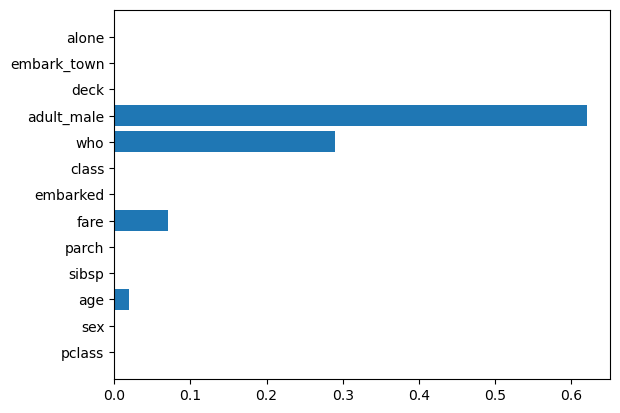

In [10]:
# 特徴量の重要度
# ada.feature_importances_
plt.barh(X.columns, ada.feature_importances_)

## 勾配ブースティング 回帰

In [30]:
class MyGradientBoostingRegressor:
    
    def __init__(self, learning_rate=0.03, n_estimators=100, max_depth=1, random_state=0):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators = [] # 弱学習器を格納
        
    def fit(self, X, y):
        # 平均が最も損失を小さくする
        self.F0 = y.mean()
        Fb = self.F0
        
        for _ in range(self.n_estimators):
            # 残差を計算
            r = y - Fb
            # 弱学習器学習
            estimator = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            estimator.fit(X, r) # 正解データは残差r
            weight = estimator.predict(X)
            # shrinkage(学習率)をかけて足し合わせていく
            # この時weightはNumPyArrayなので，Fbもイテレーション後はNumPyArrayになる
            Fb += self.learning_rate * weight
            self.estimators.append(estimator)
            
    def predict(self, X):
        Fb = self.F0
        
        for estimator in self.estimators:
            Fb += self.learning_rate * estimator.predict(X)
            
        return Fb

<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

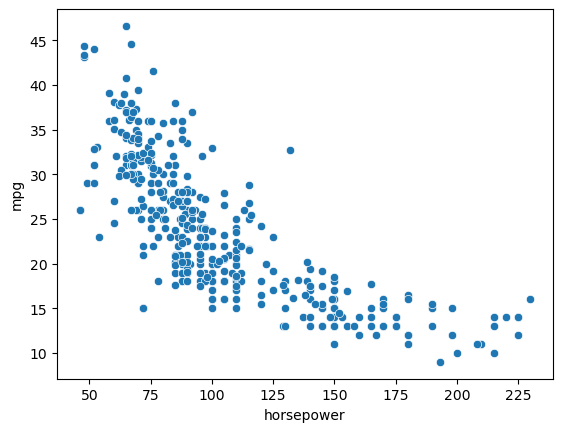

In [31]:
# データ準備
df = sns.load_dataset('mpg')
df.dropna(inplace=True)
X = df['horsepower'].values.reshape(-1, 1)
y = df['mpg'].values
sns.scatterplot(x=df['horsepower'], y=df['mpg'])

In [36]:
my_gbr = MyGradientBoostingRegressor()
my_gbr.fit(X, y)
my_gbr.predict(X)[:10]

array([17.95434839, 15.74535562, 15.74535562, 15.74535562, 16.96376992,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 15.74535562])

### sklearnのGradientBoostingRegressorを使う

In [45]:
lr = 0.03
gbr = GradientBoostingRegressor(max_depth=1, learning_rate=lr, random_state=0).fit(X, y)

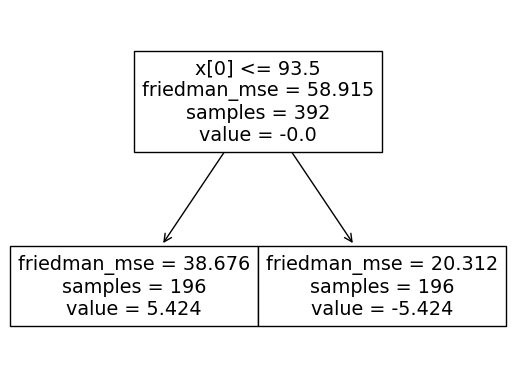

In [46]:
# 決定木で確認
model = gbr.estimators_[1][0]
_ = plot_tree(model)

In [48]:
results = []
idx = 0
for t in gbr.estimators_:
    result = t[0].predict([X[idx]])
    results.append(result*lr)    

In [49]:
F0 = np.mean(y)
Fb = F0 + np.cumsum(results)

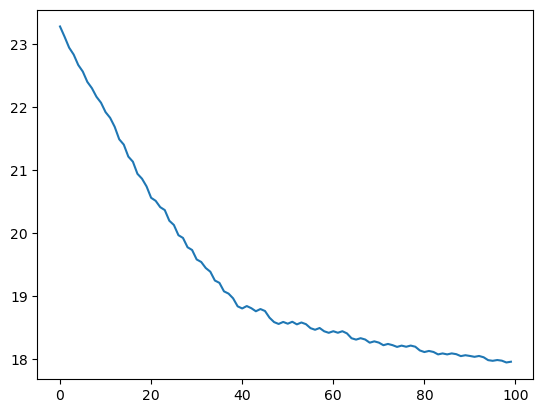

In [53]:
plt.plot(Fb)